In [1]:
import torch
import numpy as np
import scipy.io as sio
import os
import time
from scipy import stats

import gc

gc.collect()

0

In [2]:
class EnsemblePursuitPyTorch():
    
    def calculate_cost_delta(self):
        cost_delta=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)**2/torch.matmul(self.current_v,self.current_v)-self.lambd
        #print('mean cost_delta',torch.mean(cost_delta))
        return cost_delta
    
    def fit_one_assembly(self):
        with torch.cuda.device(0) as device:
            top_corr_neuron=self.select_top_k_corr_neuron()
            print('neuron',top_corr_neuron)
            #print('corr',top_corr_neuron)
            #print('chosen neuron',top_corr_neuron)
            #choose_neuron_idx=np.random.randint(0,self.sz[1],1)[0]
            choose_neuron_idx=top_corr_neuron
            #print(choose_neuron_idx)
            self.selected_neurons=torch.zeros([self.sz[1]]).cuda()
            self.selected_neurons[choose_neuron_idx]=1
            self.current_v=self.X[:,choose_neuron_idx]+self.epsilon
            max_delta_cost=1000
            self.i=0
            while max_delta_cost>0:
                cost_delta=self.calculate_cost_delta()
                #print(cost_delta.size())
                #print(self.current_u.size())
                mask=self.selected_neurons.clone()
                mask[self.selected_neurons==0]=1
                mask[self.selected_neurons!=0]=0
                masked_cost_delta=mask*cost_delta
                #print(masked_cost_delta.type())
                #print(masked_cost_delta)
                values,sorted_neurons=masked_cost_delta.sort()
                max_delta_neuron=sorted_neurons[-1]
                #print(max_delta_neuron.item())
                #print(values)
                max_delta_cost=values[-1]
                #print('max delta',max_delta_cost)
                self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
                #print(self.current_u[max_delta_neuron])
                if max_delta_cost>0:
                    self.current_v=(self.current_v+self.X[:,max_delta_neuron.item()])/2
                    self.selected_neurons[max_delta_neuron.item()]=1
                self.i+=1
            #print(i)
            self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
            self.U=torch.cat((self.U,self.current_u.view(self.X.size(1),1)),1)
            self.V=torch.cat((self.V,self.current_v.view(1,self.X.size(0))),0)
    
    def corrcoef(self,x):
        """
        Mimics `np.corrcoef`

        Arguments
        ---------
        x : 2D torch.Tensor

        Returns
        -------
        c : torch.Tensor
            if x.size() = (5, 100), then return val will be of size (5,5)

        Numpy docs ref:
            https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
        Numpy code ref: 
            https://github.com/numpy/numpy/blob/v1.12.0/numpy/lib/function_base.py#L2933-L3013

        Example:
            >>> x = np.random.randn(5,120)
            # result is a (5,5) matrix of correlations between rows
            >>> np_corr = np.corrcoef(x)
            >>> th_corr = corrcoef(torch.from_numpy(x))
            >>> np.allclose(np_corr, th_corr.numpy())
            # [out]: True
        """
        # calculate covariance matrix of columns
        mean_x = torch.mean(x,0)
        #print(mean_x.size())
        #print(mean_x.expand_as(x))
        xm = torch.sub(x,mean_x)
        c = x.mm(x.t())
        c = c / (x.size(1) - 1)

        # normalize covariance matrix
        d = torch.diag(c)
        stddev = torch.pow(d, 0.5)
        c = c.div(stddev.expand_as(c))
        c = c.div(stddev.expand_as(c).t())

        # clamp between -1 and 1
        # probably not necessary but numpy does it
        c = torch.clamp(c, -1.0, 1.0)

        return c
    
    def select_top_k_corr_neuron(self):
        corr=self.corrcoef(self.X.t())
        vals,ix=corr.sort(dim=1)
        top_vals=vals[:,:-1][:,self.sz[1]-6:]
        #print(top_vals)
        av=torch.mean(top_vals,dim=1)
        vals,top_neurons=torch.sort(av)
        top_neuron=top_neurons[self.sz[1]-101:]
        top_val=vals[self.sz[1]-101:]
        idx=torch.randint(0,100,size=(1,))
        print(idx)
        print('top n', top_neuron[idx[0]], top_val[idx[0]])
        return top_neuron[idx[0]].item()
    
    
    def fit_transform(self,X,lambd,n_ensembles=None):
        with torch.cuda.device(0) as device:
            self.lambd=lambd
            print(X)
            self.X=stats.zscore(X,axis=0)
            #self.X=np.nan_to_num(self.X)
            print(np.mean(self.X,axis=0))
            self.X=torch.cuda.FloatTensor(self.X) 
            print(self.X)
            self.sz=self.X.size()
            print(self.sz[0],self.sz[1])
            self.U=torch.zeros((self.X.size(1),1)).cuda()
            self.V=torch.zeros([1,self.X.size(0)]).cuda()
            self.nr_of_neurons=[]
            self.epsilon=0.0000000001
            #self.current_u=torch.zeros([self.X.size(1)]).cuda()
            cost_lst=[]
            for iteration in range(0,n_ensembles):
                self.fit_one_assembly()
                self.nr_of_neurons.append(self.i)
                U_V=torch.mm(self.current_u.view(self.sz[1],1),self.current_v.view(1,self.sz[0]))
                U_V[U_V != U_V] = 0
                #print(U_V.size())
                res=(self.X-U_V.t())
                self.X=res
                #self.X=torch.cuda.FloatTensor(stats.zscore(np.array(self.X.cpu()+self.epsilon)))
                #self.X[self.X != self.X] = 0
                #rint('self.X',self.X)
                print('ensemble nr', iteration)
                print('u',self.current_u)
                print('v',self.current_v)
                print('length v', torch.matmul(self.current_v,self.current_v))
                print('norm',torch.norm(self.X))
                self.cost=torch.mean(torch.mul(res,res))
                #print('cost',self.cost)
                cost_lst.append(self.cost.item())
                #Reset u for new iteration
            self.U=self.U[:,1:]
            self.V=self.V[1:,:]
            print(self.X.size())
            print(self.U.size())
            print(self.V.size())
            return torch.matmul(self.U,self.V).t().cpu(), self.nr_of_neurons, self.U.cpu(), self.V.cpu(), cost_lst

In [3]:
X=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
X[X<0]=0
print(X.shape)
for col in range(0,X.shape[1]):
    if np.sum(X[:,col]==0)==X.shape[0]:
        print(col)
X=np.delete(X,8574,1)
print(X.shape)
for col in range(0,X.shape[1]):
    if np.sum(X[:,col]==0)==X.shape[0]:
        print(col)

(5880, 10103)
8574
(5880, 10102)


In [4]:
print(X.shape)
np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
U_V,nr_of_neurons,U,V, cost_lst=ep.fit_transform(X,300,500)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

(5880, 10102)
[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]
[-2.46528060e-08 -7.78509630e-08 -5.44956755e-08 ...  1.29751605e-08
 -1.94627403e-09  5.19006438e-09]
tensor([[ 1.1550, -0.1022, -0.5535,  ...,  0.5873, -0.8588, -0.7753],
        [ 1.7695, -0.8956, -0.5535,  ..., -0.8096,  0.8385,  0.5909],
        [-0.7333, -0.8956, -0.5535,  ...,  2.7760, -0.0089,  0.0565],
        ...,
        [ 0.0041,  0.4383, -0.5535,  ..., -0.2054,  1.2692,  0.0694],
        [ 0.1372,  1.0639, -0.5535,  ..., -0.6713, -0.8588,  0.2557],
        [-0.6942,  1.3257, -0.5535,  ..., -0.8096, -0

tensor([52])
top n tensor(1041, device='cuda:0') tensor(0.4192, device='cuda:0')
neuron 1041
ensemble nr 20
u tensor([0.0312, 0.0974, 0.0450,  ..., 0.0458, 0.0444, 0.0407], device='cuda:0')
v tensor([-0.0324, -0.1631, -0.2401,  ...,  0.1274, -0.4903, -0.0361],
       device='cuda:0')
length v tensor(2614.6152, device='cuda:0')
norm tensor(7602.9736, device='cuda:0')
tensor([26])
top n tensor(2096, device='cuda:0') tensor(0.4025, device='cuda:0')
neuron 2096
ensemble nr 21
u tensor([0.0419, 0.0723, 0.0624,  ..., 0.0000, 0.0000, 0.1032], device='cuda:0')
v tensor([ 0.4172, -0.0415, -0.2128,  ..., -0.2889,  0.0844, -0.0859],
       device='cuda:0')
length v tensor(2576.1074, device='cuda:0')
norm tensor(7598.7993, device='cuda:0')
tensor([20])
top n tensor(3033, device='cuda:0') tensor(0.3976, device='cuda:0')
neuron 3033
ensemble nr 22
u tensor([0.0690, 0.0660, 0.0694,  ..., 0.0000, 0.0000, 0.0163], device='cuda:0')
v tensor([ 0.1707, -0.3325, -0.0881,  ..., -0.0614, -0.5786,  0.5952],
 

ensemble nr 42
u tensor([0.0108, 0.0000, 0.0097,  ..., 0.0000, 0.0124, 0.0000], device='cuda:0')
v tensor([-0.0115, -0.2176,  0.1547,  ..., -0.2815,  0.0023, -0.0821],
       device='cuda:0')
length v tensor(2544.1155, device='cuda:0')
norm tensor(7526.6938, device='cuda:0')
tensor([72])
top n tensor(706, device='cuda:0') tensor(0.4210, device='cuda:0')
neuron 706
ensemble nr 43
u tensor([0.0000, 0.0057, 0.0654,  ..., 0.0000, 0.0000, 0.0350], device='cuda:0')
v tensor([ 0.8901, -0.3470,  0.0290,  ...,  0.6235,  0.0351, -0.8038],
       device='cuda:0')
length v tensor(2728.6685, device='cuda:0')
norm tensor(7523.9746, device='cuda:0')
tensor([52])
top n tensor(7685, device='cuda:0') tensor(0.4071, device='cuda:0')
neuron 7685
ensemble nr 44
u tensor([0.0207, 0.0313, 0.0174,  ..., 0.0848, 0.0332, 0.0290], device='cuda:0')
v tensor([-0.1491, -0.4112,  0.5817,  ...,  0.0569, -0.0491, -0.2100],
       device='cuda:0')
length v tensor(2616.8223, device='cuda:0')
norm tensor(7520.4238, devic

tensor([27])
top n tensor(3276, device='cuda:0') tensor(0.3775, device='cuda:0')
neuron 3276
ensemble nr 65
u tensor([0.0056, 0.0304, 0.0000,  ..., 0.0144, 0.0000, 0.0392], device='cuda:0')
v tensor([-0.3403,  0.3413, -0.0959,  ..., -0.7504,  0.4816, -0.2296],
       device='cuda:0')
length v tensor(2644.9426, device='cuda:0')
norm tensor(7455.1216, device='cuda:0')
tensor([6])
top n tensor(3488, device='cuda:0') tensor(0.3684, device='cuda:0')
neuron 3488
ensemble nr 66
u tensor([0.0600, 0.0398, 0.0608,  ..., 0.0000, 0.0114, 0.0000], device='cuda:0')
v tensor([ 0.2119,  0.5578, -0.2565,  ..., -0.0075, -0.3375, -0.3547],
       device='cuda:0')
length v tensor(2971.6111, device='cuda:0')
norm tensor(7452.4351, device='cuda:0')
tensor([61])
top n tensor(8217, device='cuda:0') tensor(0.3968, device='cuda:0')
neuron 8217
ensemble nr 67
u tensor([0.0337, 0.0000, 0.0155,  ..., 0.0343, 0.0000, 0.0340], device='cuda:0')
v tensor([ 0.1170,  0.1175, -0.3139,  ..., -0.3517, -0.3547, -0.2136],
  

ensemble nr 87
u tensor([0.0000, 0.0000, 0.0000,  ..., 0.0149, 0.0108, 0.0125], device='cuda:0')
v tensor([-0.3063,  0.0223, -0.3071,  ..., -0.4784, -0.6191, -0.0401],
       device='cuda:0')
length v tensor(2555.6816, device='cuda:0')
norm tensor(7395.9155, device='cuda:0')
tensor([13])
top n tensor(4484, device='cuda:0') tensor(0.3626, device='cuda:0')
neuron 4484
ensemble nr 88
u tensor([0.0286, 0.0387, 0.0000,  ..., 0.0217, 0.0442, 0.0087], device='cuda:0')
v tensor([-0.3203,  0.7019,  0.4040,  ..., -0.3771, -0.4659,  1.0492],
       device='cuda:0')
length v tensor(2560.5623, device='cuda:0')
norm tensor(7393.5576, device='cuda:0')
tensor([23])
top n tensor(4403, device='cuda:0') tensor(0.3666, device='cuda:0')
neuron 4403
ensemble nr 89
u tensor([0.0072, 0.0000, 0.0540,  ..., 0.0000, 0.0000, 0.0110], device='cuda:0')
v tensor([-0.4510, -0.2126, -0.2444,  ..., -0.5301,  1.7074, -0.3980],
       device='cuda:0')
length v tensor(2376.8093, device='cuda:0')
norm tensor(7390.4419, dev

tensor([54])
top n tensor(2495, device='cuda:0') tensor(0.3691, device='cuda:0')
neuron 2495
ensemble nr 110
u tensor([0.0000, 0.0251, 0.0615,  ..., 0.0220, 0.0051, 0.0332], device='cuda:0')
v tensor([ 0.0954, -0.3640, -0.0592,  ...,  0.2050, -0.1126, -0.1338],
       device='cuda:0')
length v tensor(2538.5542, device='cuda:0')
norm tensor(7333.6587, device='cuda:0')
tensor([82])
top n tensor(2854, device='cuda:0') tensor(0.3945, device='cuda:0')
neuron 2854
ensemble nr 111
u tensor([0.0215, 0.0000, 0.0605,  ..., 0.0258, 0.0448, 0.0000], device='cuda:0')
v tensor([ 0.0621,  0.4779,  0.9802,  ..., -0.4859, -0.3354, -0.3191],
       device='cuda:0')
length v tensor(2566.4658, device='cuda:0')
norm tensor(7331.4961, device='cuda:0')
tensor([31])
top n tensor(9631, device='cuda:0') tensor(0.3589, device='cuda:0')
neuron 9631
ensemble nr 112
u tensor([0.0139, 0.0000, 0.0162,  ..., 0.0059, 0.0205, 0.0213], device='cuda:0')
v tensor([ 0.5025, -0.3909, -0.4539,  ...,  0.3571, -0.4043, -0.1022]

tensor([64])
top n tensor(2650, device='cuda:0') tensor(0.3607, device='cuda:0')
neuron 2650
ensemble nr 133
u tensor([0.0000, 0.0312, 0.0134,  ..., 0.0000, 0.0121, 0.0099], device='cuda:0')
v tensor([-0.4480, -0.1757, -0.3018,  ..., -0.4870, -0.2055,  0.0029],
       device='cuda:0')
length v tensor(3152.6860, device='cuda:0')
norm tensor(7280.0073, device='cuda:0')
tensor([26])
top n tensor(5005, device='cuda:0') tensor(0.3398, device='cuda:0')
neuron 5005
ensemble nr 134
u tensor([0.0169, 0.0407, 0.0000,  ..., 0.0000, 0.0000, 0.0283], device='cuda:0')
v tensor([ 0.4462, -0.3722, -0.6272,  ...,  0.2818, -0.7056, -0.1787],
       device='cuda:0')
length v tensor(2826.1980, device='cuda:0')
norm tensor(7277.7368, device='cuda:0')
tensor([80])
top n tensor(4115, device='cuda:0') tensor(0.3699, device='cuda:0')
neuron 4115
ensemble nr 135
u tensor([0.0000, 0.0000, 0.0000,  ..., 0.0090, 0.0055, 0.0162], device='cuda:0')
v tensor([-0.2005,  0.0689,  0.6067,  ...,  1.3387, -0.5972, -0.2139]

tensor([56])
top n tensor(3065, device='cuda:0') tensor(0.3372, device='cuda:0')
neuron 3065
ensemble nr 156
u tensor([0.0000, 0.0000, 0.0075,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([ 0.1266, -0.1702,  0.0145,  ...,  0.5710,  2.4305, -0.2642],
       device='cuda:0')
length v tensor(2541.2231, device='cuda:0')
norm tensor(7227.5078, device='cuda:0')
tensor([98])
top n tensor(3100, device='cuda:0') tensor(0.4123, device='cuda:0')
neuron 3100
ensemble nr 157
u tensor([0.0000, 0.0000, 0.0071,  ..., 0.0089, 0.0227, 0.0000], device='cuda:0')
v tensor([-0.1798, -0.2208, -0.0548,  ...,  0.8164, -0.3764,  0.3082],
       device='cuda:0')
length v tensor(2300.9119, device='cuda:0')
norm tensor(7225.5918, device='cuda:0')
tensor([63])
top n tensor(9901, device='cuda:0') tensor(0.3401, device='cuda:0')
neuron 9901
ensemble nr 158
u tensor([0.0096, 0.0008, 0.0000,  ..., 0.0000, 0.0000, 0.0654], device='cuda:0')
v tensor([-0.1261, -0.3383, -0.5063,  ...,  0.0786, -0.3480, -0.6063]

tensor([36])
top n tensor(3643, device='cuda:0') tensor(0.3197, device='cuda:0')
neuron 3643
ensemble nr 179
u tensor([0.0250, 0.0505, 0.0117,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.5006,  0.1326, -0.3353,  ...,  0.4604, -0.5146, -0.4315],
       device='cuda:0')
length v tensor(4097.2993, device='cuda:0')
norm tensor(7179.3667, device='cuda:0')
tensor([81])
top n tensor(1837, device='cuda:0') tensor(0.3486, device='cuda:0')
neuron 1837
ensemble nr 180
u tensor([0.0382, 0.0810, 0.0000,  ..., 0.0587, 0.0805, 0.0000], device='cuda:0')
v tensor([ 0.1707, -0.1940, -0.5375,  ..., -0.2548, -0.3583, -0.1762],
       device='cuda:0')
length v tensor(2491.7671, device='cuda:0')
norm tensor(7177.2349, device='cuda:0')
tensor([52])
top n tensor(2703, device='cuda:0') tensor(0.3239, device='cuda:0')
neuron 2703
ensemble nr 181
u tensor([0.0040, 0.0017, 0.0000,  ..., 0.0000, 0.0000, 0.0171], device='cuda:0')
v tensor([ 0.5389,  0.4302,  0.9437,  ..., -0.0243, -0.1850, -0.1248]

tensor([84])
top n tensor(3522, device='cuda:0') tensor(0.3397, device='cuda:0')
neuron 3522
ensemble nr 202
u tensor([0.0043, 0.0234, 0.0164,  ..., 0.0160, 0.0000, 0.0000], device='cuda:0')
v tensor([ 0.0617,  0.0354,  0.2917,  ..., -0.1675, -0.6490,  0.1994],
       device='cuda:0')
length v tensor(2093.1851, device='cuda:0')
norm tensor(7128.8203, device='cuda:0')
tensor([32])
top n tensor(6414, device='cuda:0') tensor(0.3054, device='cuda:0')
neuron 6414
ensemble nr 203
u tensor([0.0095, 0.0368, 0.0101,  ..., 0.0585, 0.0000, 0.0136], device='cuda:0')
v tensor([-0.3081, -0.1556,  0.5025,  ..., -0.1461,  0.0339, -0.3279],
       device='cuda:0')
length v tensor(2014.5098, device='cuda:0')
norm tensor(7126.7690, device='cuda:0')
tensor([47])
top n tensor(3442, device='cuda:0') tensor(0.3085, device='cuda:0')
neuron 3442
ensemble nr 204
u tensor([0.0000, 0.0053, 0.0000,  ..., 0.0159, 0.0100, 0.0516], device='cuda:0')
v tensor([-0.6503,  0.1689, -0.1574,  ..., -0.1664, -0.1527, -0.3347]

tensor([32])
top n tensor(5262, device='cuda:0') tensor(0.2902, device='cuda:0')
neuron 5262
ensemble nr 225
u tensor([0.0239, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.0397,  0.1496, -0.0744,  ..., -0.1599,  0.2024, -0.1938],
       device='cuda:0')
length v tensor(2564.3569, device='cuda:0')
norm tensor(7084.2451, device='cuda:0')
tensor([67])
top n tensor(6197, device='cuda:0') tensor(0.3045, device='cuda:0')
neuron 6197
ensemble nr 226
u tensor([0.0187, 0.0235, 0.0000,  ..., 0.0048, 0.0203, 0.0000], device='cuda:0')
v tensor([-0.0390, -0.3291, -0.0430,  ...,  0.1711, -0.1667,  0.4136],
       device='cuda:0')
length v tensor(2466.7803, device='cuda:0')
norm tensor(7082.6172, device='cuda:0')
tensor([9])
top n tensor(523, device='cuda:0') tensor(0.2836, device='cuda:0')
neuron 523
ensemble nr 227
u tensor([0.0519, 0.0072, 0.0189,  ..., 0.0000, 0.0000, 0.0326], device='cuda:0')
v tensor([ 0.3848, -0.0148, -0.4465,  ..., -0.0460, -0.4348,  0.1099],
 

tensor([40])
top n tensor(2283, device='cuda:0') tensor(0.2826, device='cuda:0')
neuron 2283
ensemble nr 248
u tensor([0.0000, 0.0087, 0.0296,  ..., 0.0179, 0.0138, 0.0265], device='cuda:0')
v tensor([ 0.6784, -0.2441, -0.4243,  ..., -0.5385,  0.5484,  0.3514],
       device='cuda:0')
length v tensor(2530.5029, device='cuda:0')
norm tensor(7040.8833, device='cuda:0')
tensor([60])
top n tensor(1568, device='cuda:0') tensor(0.2886, device='cuda:0')
neuron 1568
ensemble nr 249
u tensor([0.0095, 0.0000, 0.0031,  ..., 0.0018, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.1219, -0.4342, -0.0568,  ..., -0.5966,  0.6175,  0.2325],
       device='cuda:0')
length v tensor(3393.6624, device='cuda:0')
norm tensor(7039.6421, device='cuda:0')
tensor([41])
top n tensor(3427, device='cuda:0') tensor(0.2811, device='cuda:0')
neuron 3427
ensemble nr 250
u tensor([0.0000, 0.0000, 0.0205,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.1529, -0.0504,  0.0293,  ..., -0.3606, -0.1096,  0.0972]

tensor([7])
top n tensor(9969, device='cuda:0') tensor(0.2602, device='cuda:0')
neuron 9969
ensemble nr 271
u tensor([0.0367, 0.0000, 0.0077,  ..., 0.0096, 0.0269, 0.0632], device='cuda:0')
v tensor([-0.5746, -0.5925, -0.2815,  ..., -0.6070,  0.2419, -0.5014],
       device='cuda:0')
length v tensor(2128.3064, device='cuda:0')
norm tensor(7000.0098, device='cuda:0')
tensor([8])
top n tensor(2398, device='cuda:0') tensor(0.2603, device='cuda:0')
neuron 2398
ensemble nr 272
u tensor([0.0722, 0.0155, 0.0324,  ..., 0.0000, 0.0164, 0.0000], device='cuda:0')
v tensor([ 0.8225,  0.1188,  0.2035,  ...,  0.5279, -0.0197,  0.2063],
       device='cuda:0')
length v tensor(2459.9644, device='cuda:0')
norm tensor(6998.8906, device='cuda:0')
tensor([4])
top n tensor(4346, device='cuda:0') tensor(0.2592, device='cuda:0')
neuron 4346
ensemble nr 273
u tensor([0.0000, 0.0257, 0.0000,  ..., 0.0000, 0.0120, 0.0041], device='cuda:0')
v tensor([-0.2092, -0.1181,  0.1913,  ...,  0.1983,  0.4036, -0.4149],
 

tensor([37])
top n tensor(1455, device='cuda:0') tensor(0.2568, device='cuda:0')
neuron 1455
ensemble nr 294
u tensor([0.0000, 0.0100, 0.0000,  ..., 0.0199, 0.0078, 0.0170], device='cuda:0')
v tensor([-0.2579,  0.4021,  0.3541,  ...,  0.2693, -0.2908,  2.7103],
       device='cuda:0')
length v tensor(2252.1763, device='cuda:0')
norm tensor(6959.3613, device='cuda:0')
tensor([66])
top n tensor(3991, device='cuda:0') tensor(0.2657, device='cuda:0')
neuron 3991
ensemble nr 295
u tensor([0.0000, 0.0000, 0.0000,  ..., 0.0277, 0.0000, 0.0030], device='cuda:0')
v tensor([-0.3378, -0.2436,  0.1053,  ...,  0.2182,  0.0472, -0.1444],
       device='cuda:0')
length v tensor(3148.4133, device='cuda:0')
norm tensor(6958.1719, device='cuda:0')
tensor([72])
top n tensor(3938, device='cuda:0') tensor(0.2695, device='cuda:0')
neuron 3938
ensemble nr 296
u tensor([0.0074, 0.0000, 0.0027,  ..., 0.0000, 0.0005, 0.0000], device='cuda:0')
v tensor([-0.7235,  0.3395,  1.8270,  ..., -0.0650,  0.3078, -0.1369]

tensor([31])
top n tensor(3254, device='cuda:0') tensor(0.2503, device='cuda:0')
neuron 3254
ensemble nr 317
u tensor([0.0094, 0.0000, 0.0000,  ..., 0.0000, 0.0033, 0.0504], device='cuda:0')
v tensor([-0.2822,  0.1126, -0.1039,  ..., -0.6488, -0.2920, -0.0142],
       device='cuda:0')
length v tensor(2139.4790, device='cuda:0')
norm tensor(6921.6235, device='cuda:0')
tensor([97])
top n tensor(5005, device='cuda:0') tensor(0.3002, device='cuda:0')
neuron 5005
ensemble nr 318
u tensor([0.0000, 0.0000, 0.0274,  ..., 0.0502, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.0730, -0.1047,  0.0033,  ...,  1.3931, -0.0063, -0.0867],
       device='cuda:0')
length v tensor(2388.5488, device='cuda:0')
norm tensor(6919.7759, device='cuda:0')
tensor([80])
top n tensor(8785, device='cuda:0') tensor(0.2713, device='cuda:0')
neuron 8785
ensemble nr 319
u tensor([0.0000, 0.0000, 0.0578,  ..., 0.0000, 0.0333, 0.0082], device='cuda:0')
v tensor([-0.3237,  0.2567,  0.1419,  ..., -0.2775,  0.3573, -0.2291]

tensor([5])
top n tensor(2632, device='cuda:0') tensor(0.2374, device='cuda:0')
neuron 2632
ensemble nr 340
u tensor([0.0232, 0.0012, 0.0225,  ..., 0.0049, 0.0042, 0.0097], device='cuda:0')
v tensor([ 0.2591,  0.5223,  0.1050,  ..., -0.7742, -0.0152,  0.0563],
       device='cuda:0')
length v tensor(2640.1228, device='cuda:0')
norm tensor(6883.5747, device='cuda:0')
tensor([61])
top n tensor(339, device='cuda:0') tensor(0.2471, device='cuda:0')
neuron 339
ensemble nr 341
u tensor([0.0164, 0.0000, 0.0024,  ..., 0.0000, 0.0233, 0.0000], device='cuda:0')
v tensor([-0.1747, -0.1157,  0.3189,  ..., -0.7477, -0.0516, -0.3761],
       device='cuda:0')
length v tensor(3168.0364, device='cuda:0')
norm tensor(6882.2070, device='cuda:0')
tensor([89])
top n tensor(678, device='cuda:0') tensor(0.2624, device='cuda:0')
neuron 678
ensemble nr 342
u tensor([0.0253, 0.0000, 0.0154,  ..., 0.0000, 0.0146, 0.0000], device='cuda:0')
v tensor([-0.4296, -0.1759, -0.0440,  ...,  0.9700, -0.4084, -0.2581],
   

tensor([56])
top n tensor(6444, device='cuda:0') tensor(0.2407, device='cuda:0')
neuron 6444
ensemble nr 363
u tensor([0.0187, 0.0000, 0.0129,  ..., 0.0034, 0.0000, 0.0791], device='cuda:0')
v tensor([-0.5445,  0.6430, -0.4419,  ...,  3.8959,  0.6807, -0.2113],
       device='cuda:0')
length v tensor(3303.4897, device='cuda:0')
norm tensor(6848.4648, device='cuda:0')
tensor([94])
top n tensor(6197, device='cuda:0') tensor(0.2752, device='cuda:0')
neuron 6197
ensemble nr 364
u tensor([0.0000, 0.0019, 0.0000,  ..., 0.0295, 0.0262, 0.0000], device='cuda:0')
v tensor([-0.6946, -0.2310, -0.0898,  ..., -0.6849, -0.2090, -0.2512],
       device='cuda:0')
length v tensor(2090.0520, device='cuda:0')
norm tensor(6846.8911, device='cuda:0')
tensor([30])
top n tensor(6954, device='cuda:0') tensor(0.2350, device='cuda:0')
neuron 6954
ensemble nr 365
u tensor([0.0334, 0.0410, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.3636, -0.1965, -0.2854,  ..., -0.4105, -0.4878,  2.7232]

tensor([25])
top n tensor(6423, device='cuda:0') tensor(0.2290, device='cuda:0')
neuron 6423
ensemble nr 386
u tensor([0.0239, 0.0114, 0.0123,  ..., 0.0131, 0.0000, 0.0279], device='cuda:0')
v tensor([-0.2999, -0.0368,  0.5285,  ..., -0.4506,  0.2266, -0.1983],
       device='cuda:0')
length v tensor(2133.2983, device='cuda:0')
norm tensor(6814.5078, device='cuda:0')
tensor([41])
top n tensor(2546, device='cuda:0') tensor(0.2315, device='cuda:0')
neuron 2546
ensemble nr 387
u tensor([0.0083, 0.0000, 0.0100,  ..., 0.0148, 0.0000, 0.0249], device='cuda:0')
v tensor([-0.0949, -0.3311, -0.0202,  ..., -0.1570,  0.4486, -0.4621],
       device='cuda:0')
length v tensor(4252.5669, device='cuda:0')
norm tensor(6813.3237, device='cuda:0')
tensor([57])
top n tensor(9458, device='cuda:0') tensor(0.2361, device='cuda:0')
neuron 9458
ensemble nr 388
u tensor([0.0116, 0.0185, 0.0255,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.0443, -0.2936, -0.2464,  ..., -0.6438, -0.6775, -0.4178]

tensor([18])
top n tensor(7372, device='cuda:0') tensor(0.2205, device='cuda:0')
neuron 7372
ensemble nr 409
u tensor([0.0000, 0.0000, 0.0164,  ..., 0.0000, 0.0374, 0.0000], device='cuda:0')
v tensor([ 2.6687, -0.0428,  3.0710,  ..., -1.2878, -0.3216,  0.2388],
       device='cuda:0')
length v tensor(4741.7725, device='cuda:0')
norm tensor(6780.3882, device='cuda:0')
tensor([22])
top n tensor(9109, device='cuda:0') tensor(0.2213, device='cuda:0')
neuron 9109
ensemble nr 410
u tensor([0.0000, 0.0197, 0.0007,  ..., 0.0043, 0.0000, 0.0000], device='cuda:0')
v tensor([ 0.2890, -0.1648, -0.5367,  ..., -0.3924,  1.5465, -0.6413],
       device='cuda:0')
length v tensor(3247.6787, device='cuda:0')
norm tensor(6778.9639, device='cuda:0')
tensor([67])
top n tensor(7099, device='cuda:0') tensor(0.2323, device='cuda:0')
neuron 7099
ensemble nr 411
u tensor([0.0110, 0.0000, 0.0373,  ..., 0.0042, 0.0163, 0.0000], device='cuda:0')
v tensor([-0.5828,  0.2886,  0.0357,  ..., -0.2399, -0.6608, -0.3098]

tensor([26])
top n tensor(5649, device='cuda:0') tensor(0.2174, device='cuda:0')
neuron 5649
ensemble nr 432
u tensor([0.0008, 0.0094, 0.0225,  ..., 0.0000, 0.0000, 0.0083], device='cuda:0')
v tensor([-0.2402, -0.1239,  0.5128,  ..., -0.1291, -0.7130,  0.0789],
       device='cuda:0')
length v tensor(2998.8008, device='cuda:0')
norm tensor(6748.3452, device='cuda:0')
tensor([29])
top n tensor(3590, device='cuda:0') tensor(0.2175, device='cuda:0')
neuron 3590
ensemble nr 433
u tensor([0.0108, 0.0143, 0.0063,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')
v tensor([-0.4957,  0.5537, -0.1304,  ..., -0.6941, -1.2910, -0.1418],
       device='cuda:0')
length v tensor(1733.2814, device='cuda:0')
norm tensor(6746.9150, device='cuda:0')
tensor([65])
top n tensor(2534, device='cuda:0') tensor(0.2235, device='cuda:0')
neuron 2534
ensemble nr 434
u tensor([0.0000, 0.0218, 0.0000,  ..., 0.0155, 0.0045, 0.0028], device='cuda:0')
v tensor([-0.0755, -0.3180,  0.1879,  ...,  0.9901, -0.8573, -0.1874]

tensor([72])
top n tensor(6169, device='cuda:0') tensor(0.2223, device='cuda:0')
neuron 6169
ensemble nr 455
u tensor([0.0092, 0.0000, 0.0568,  ..., 0.0173, 0.0125, 0.0085], device='cuda:0')
v tensor([-0.3517, -0.0211,  0.1003,  ..., -0.6083, -0.2304, -0.2058],
       device='cuda:0')
length v tensor(2437.2959, device='cuda:0')
norm tensor(6716.4604, device='cuda:0')
tensor([80])
top n tensor(4154, device='cuda:0') tensor(0.2263, device='cuda:0')
neuron 4154
ensemble nr 456
u tensor([0.0000, 0.0045, 0.0000,  ..., 0.0109, 0.0000, 0.0208], device='cuda:0')
v tensor([-0.4273,  0.1250, -0.2383,  ..., -1.1904, -0.0945, -0.0146],
       device='cuda:0')
length v tensor(4419.1431, device='cuda:0')
norm tensor(6715.1650, device='cuda:0')
tensor([44])
top n tensor(4403, device='cuda:0') tensor(0.2147, device='cuda:0')
neuron 4403
ensemble nr 457
u tensor([0.0055, 0.0047, 0.0076,  ..., 0.0355, 0.0053, 0.0141], device='cuda:0')
v tensor([ 0.4922, -0.0855, -0.2162,  ..., -0.3221, -0.0178,  0.6566]

tensor([99])
top n tensor(3232, device='cuda:0') tensor(0.2471, device='cuda:0')
neuron 3232
ensemble nr 478
u tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0046, 0.0000], device='cuda:0')
v tensor([-0.3743, -0.0085, -0.2325,  ...,  0.2523, -0.7188,  0.5542],
       device='cuda:0')
length v tensor(1931.9302, device='cuda:0')
norm tensor(6686.1997, device='cuda:0')
tensor([40])
top n tensor(7565, device='cuda:0') tensor(0.2111, device='cuda:0')
neuron 7565
ensemble nr 479
u tensor([0.0275, 0.0495, 0.0000,  ..., 0.0264, 0.0530, 0.0000], device='cuda:0')
v tensor([-0.2774, -0.3261,  0.0860,  ...,  0.2142,  0.0996, -0.6447],
       device='cuda:0')
length v tensor(2923.5774, device='cuda:0')
norm tensor(6684.5601, device='cuda:0')
tensor([8])
top n tensor(4216, device='cuda:0') tensor(0.2068, device='cuda:0')
neuron 4216
ensemble nr 480
u tensor([0.0227, 0.0099, 0.0029,  ..., 0.0000, 0.0232, 0.0207], device='cuda:0')
v tensor([ 0.5196,  0.2741, -0.2851,  ...,  0.6182,  0.0079, -0.7156],

1108.6615717411041
[171, 299, 340, 779, 485, 342, 4, 440, 9, 516, 586, 482, 119, 391, 339, 139, 199, 170, 349, 354, 713, 193, 516, 180, 34, 241, 211, 186, 4, 484, 546, 160, 93, 26, 185, 119, 414, 102, 333, 261, 97, 59, 349, 91, 267, 172, 200, 194, 167, 144, 150, 36, 73, 186, 271, 35, 214, 154, 101, 78, 211, 21, 84, 151, 230, 238, 267, 40, 123, 184, 27, 123, 202, 131, 194, 12, 242, 155, 39, 112, 94, 135, 77, 252, 7, 47, 176, 76, 9, 136, 19, 113, 43, 38, 144, 6, 77, 107, 108, 21, 64, 113, 40, 19, 63, 16, 115, 95, 5, 27, 20, 31, 43, 40, 77, 21, 42, 15, 40, 46, 33, 30, 50, 36, 28, 15, 11, 10, 5, 6, 43, 15, 20, 6, 67, 63, 24, 20, 49, 30, 71, 45, 3, 9, 52, 23, 13, 24, 4, 8, 3, 2, 9, 19, 16, 4, 5, 27, 9, 32, 23, 29, 4, 20, 3, 7, 3, 5, 40, 26, 5, 5, 20, 11, 7, 27, 21, 3, 15, 3, 8, 3, 30, 13, 17, 14, 3, 8, 27, 2, 23, 34, 8, 26, 7, 2, 18, 20, 38, 60, 4, 12, 5, 13, 25, 10, 4, 3, 4, 17, 14, 3, 6, 2, 3, 3, 5, 5, 9, 3, 4, 6, 18, 9, 4, 3, 11, 3, 7, 3, 27, 5, 4, 14, 3, 6, 6, 6, 8, 19, 8, 3, 6, 5, 8, 2

In [5]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test

def evaluate_model(x_train,x_test):
    corr_mat=np.zeros((x_train.shape[0],x_train.shape[0]))
    for j in range(0,x_train.shape[0]):
        for i in range(0,x_test.shape[0]):
            corr_mat[j,i]=np.corrcoef(x_train[j,:],x_test[i,:])[0,1]
    print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))
    
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]
x_train, x_test, y_train, y_test=test_train_split(np.nan_to_num(np.array(V.t())),stim)
evaluate_model(x_train,x_test)

0.29178571428571426


(array([423.,  28.,  21.,   9.,   7.,   3.,   5.,   2.,   0.,   2.]),
 array([  1. ,  78.8, 156.6, 234.4, 312.2, 390. , 467.8, 545.6, 623.4,
        701.2, 779. ]),
 <a list of 10 Patch objects>)

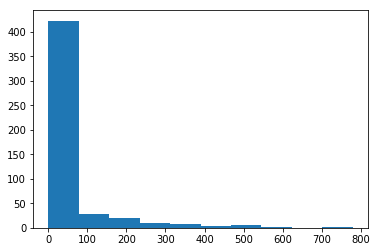

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(nr_of_neurons)